In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## Paramètres du modèle

In [ ]:
r = 0.02  # Taux sans risque
S0 = 100  # Prix initial de l'actif sous-jacent
kappa = 0.12  # Drift
sigma = 0.2  # Volatilité
hl = 0.25  # 3 mois en années
T = 5  # Maturité
Nom = 1  # Nominal
delta = 1/52 # one week in years
gamma = 0.01 # exponential default times 100 bps 

In [3]:
def black_scholes_paths(S0, r, sigma, T, dt, N_paths):
    """Génère des trajectoires de Black-Scholes par Euler-Maruyama"""
    N_steps = int(T / dt)
    S = np.zeros((N_steps + 1, N_paths))
    S[0] = S0
    for t in range(1, N_steps + 1):
        Z = np.random.normal(0, 1, N_paths)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

## Simulation Monte Carlo

In [ ]:
N_paths = 5000
dt = 1/252  # Pas journalier
S_paths = black_scholes_paths(S0, r, sigma, T, dt, N_paths)
t_grid = np.linspace(0, T, len(S_paths))

# 3. Calcul du processus MtM

def MtM(S_paths, Nom, kappa, hl, T, t):
    beta_t = np.exp(r * (T - t))
    Strike = S0
    S_hat = np.exp(-kappa * t_grid) * S_paths
    hl = 




In [20]:

# Réseau de neurones linéaire
def train_linear_nn(X, y, epochs=500, lr=0.01):
    model = nn.Linear(X.shape[1], 1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in tqdm(range(epochs), desc='Training'):
        optimizer.zero_grad()
        y_pred = model(torch.tensor(X, dtype=torch.float32))
        loss = loss_fn(y_pred, torch.tensor(y, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()
    return model

X_train = np.column_stack([t_grid[:-1], S_paths[:-1]])
y_train = np.maximum(MtM[1:] - MtM[:-1], 0).mean(axis=1)
linear_nn = train_linear_nn(X_train, y_train)


Training: 100%|██████████| 500/500 [00:04<00:00, 103.64it/s]


CVA Monte Carlo: 2.5240, CVA Formel: 59.1044


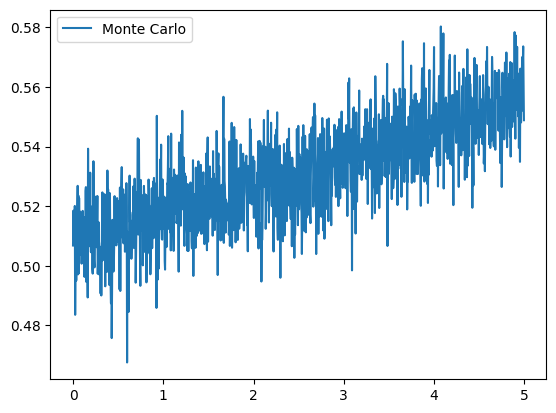

In [22]:

# 2. Validation avec Monte Carlo jumelé et Monte Carlo imbriqué
CVA_MC = np.trapz(y_train * np.exp(-r * t_grid[:-1]), t_grid[:-1])
CVA_formula = Nom * S0 * np.trapz(norm.cdf(sigma * np.sqrt(t_grid[:-1]) / 2) - norm.cdf(-sigma * np.sqrt(t_grid[:-1]) / 2), t_grid[:-1])
print(f"CVA Monte Carlo: {CVA_MC:.4f}, CVA Formel: {CVA_formula:.4f}")

# 3. Calcul de CVA₀ par intégration numérique et validation
plt.plot(t_grid[:-1], y_train, label="Monte Carlo")
plt.legend()
plt.show()


In [ ]:

# 4. Version alternative avec régression polynomiale et réseau de neurones non linéaire
def train_nonlinear_nn(X, y, epochs=500, lr=0.01):
    model = nn.Sequential(
        nn.Linear(X.shape[1], 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(torch.tensor(X, dtype=torch.float32))
        loss = loss_fn(y_pred, torch.tensor(y, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()
    return model

# Régression polynomiale
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
lin_reg = LinearRegression().fit(X_poly, y_train)

# Réseau de neurones non linéaire
nonlinear_nn = train_nonlinear_nn(X_train, y_train)

plt.plot(t_grid[:-1], y_train, label="Monte Carlo")
plt.plot(t_grid[:-1], lin_reg.predict(X_poly), label="Régression Polynomiale")
plt.legend()
plt.show()
